In [1]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Setup Up GPU (Device)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [3]:
df_tr = pd.read_csv("data/train.csv")
df_te = pd.read_csv('data/test_public.csv')

In [4]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Helper Functions

In [5]:
# (polyline_length - 1) * 15, where polyline_length = count("[") - 1
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Feature Engineering/Selection

In [6]:
# process new features
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_te[["YR", "MON", "DAY", "HR", "WK"]] = df_te[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
def compute_ohe(df, feat):
    df = df.copy()
    unique_vals = df_tr[feat].unique()
    for val in unique_vals:
        df[feat + '_' + str(val)] = df[feat].apply(lambda x: 1 if x==val else 0)
    return df

In [8]:
# drop samples with missing data (count=10)
df_tr = df_tr[df_tr['MISSING_DATA'] == False]

In [9]:
def drop_not_in_testing(df, feat):
    temp = (df_tr[feat].value_counts(normalize=True).sort_index() - df_te[feat].value_counts(normalize=True).sort_index())
    vals_to_remove = temp[temp.isna()].index
    df = df[df[feat].apply(lambda x: x not in vals_to_remove)]
    return df

In [10]:
# select useful input features

features_to_use = ['CALL_TYPE', 'MON', 'DAY', 'HR', 'WK']

X = df_tr[features_to_use]
for feat in features_to_use:
    X = compute_ohe(X, feat)
X = X.drop(columns=features_to_use)
y = df_tr['LEN']

# Train Test Split

In [11]:
# split into train,validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# drop samples with len < len_thresh
len_thresh = 2000
train_data = pd.concat([X_train, y_train], axis=1)
train_data = train_data[train_data['LEN'] < len_thresh]
X_train = train_data.drop(columns='LEN')
y_train = train_data['LEN']

# Sklearn Baseline

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [14]:
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
print(MSE(reg.predict(X_train), y_train, squared=False))
MSE(reg.predict(X_test), y_test, squared=False)

354.6358643182817


689.4356684318552

In [15]:
forest = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)
forest.fit(X_train, y_train)
print(MSE(forest.predict(X_train), y_train, squared=False))
MSE(forest.predict(X_test), y_test, squared=False)

354.17651493815157


690.4277125069815

# Convert to Tensors

In [16]:
# convert to tensors
X_train = torch.from_numpy(X_train.values).to(torch.float32)
y_train = torch.tensor(np.array(y_train)).to(torch.float32).reshape(-1,1)
X_test = torch.from_numpy(X_test.values).to(torch.float32)
y_test = torch.tensor(np.array(y_test)).to(torch.float32).reshape(-1,1)

data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

batch_size = 2**8
num_workers = 4
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Deep Learning Model

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [18]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(X.shape[1], 256),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256,64),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(64,16),
            nn.ReLU()
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(16,1)
        )
        
    def forward(self, x):
        x = self.layer1(x)      
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
         
        return x

# Train Model

In [19]:
from tqdm import tqdm

training_losses = []
validation_losses = []
criterion = nn.MSELoss()
net = model()
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

MAX_EPOCHS = 20

prev_loss = float('inf')
curr_loss = 0
conv_thresh = 1e-4

for epoch in tqdm(range(1, MAX_EPOCHS + 1, 1)):
    
    running_loss = 0
    n = 0 
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        y_pred = net(x)
        loss  = criterion(y_pred, y)
        running_loss += loss.item()*len(x)
        n += len(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    curr_loss = np.sqrt(running_loss / n)
    
    if np.abs(curr_loss - prev_loss) < conv_thresh:
        break
    
    valid_loss = MSE(net(X_test.to(device)).detach().cpu().numpy(), y_test.cpu(), squared=False)
    training_losses.append((epoch, curr_loss))
    validation_losses.append((epoch, valid_loss))
    print('epoch {}, training_loss {}, validation_loss {}'.format(epoch, curr_loss, valid_loss))
    prev_loss = curr_loss
    
print('Finished Training')

  5%|▌         | 1/20 [00:18<05:57, 18.80s/it]

epoch 1, training_loss 365.7187606340221, validation_loss 688.348876953125


 10%|█         | 2/20 [00:36<05:27, 18.21s/it]

epoch 2, training_loss 354.9800150016849, validation_loss 690.2501220703125


 15%|█▌        | 3/20 [00:54<05:08, 18.13s/it]

epoch 3, training_loss 354.9687283769341, validation_loss 689.5284423828125


 20%|██        | 4/20 [01:12<04:46, 17.92s/it]

epoch 4, training_loss 354.9847595379064, validation_loss 689.2290649414062


 25%|██▌       | 5/20 [01:29<04:23, 17.58s/it]

epoch 5, training_loss 354.9674984669962, validation_loss 687.2993774414062


 30%|███       | 6/20 [01:45<04:02, 17.29s/it]

epoch 6, training_loss 354.95589155721245, validation_loss 689.924072265625


 35%|███▌      | 7/20 [02:02<03:43, 17.19s/it]

epoch 7, training_loss 354.9154586058, validation_loss 688.6905517578125


 40%|████      | 8/20 [02:20<03:29, 17.43s/it]

epoch 8, training_loss 354.9638368190025, validation_loss 690.545166015625


 45%|████▌     | 9/20 [02:38<03:12, 17.49s/it]

epoch 9, training_loss 354.949732782348, validation_loss 692.1978759765625


 50%|█████     | 10/20 [02:55<02:52, 17.29s/it]

epoch 10, training_loss 354.94946674166454, validation_loss 689.3668823242188


 55%|█████▌    | 11/20 [03:14<02:39, 17.73s/it]

epoch 11, training_loss 354.71106981616845, validation_loss 689.2193603515625


 60%|██████    | 12/20 [03:30<02:19, 17.43s/it]

epoch 12, training_loss 354.29008233442164, validation_loss 690.1881713867188


 65%|██████▌   | 13/20 [03:47<02:01, 17.32s/it]

epoch 13, training_loss 354.0116892281757, validation_loss 688.58642578125


 70%|███████   | 14/20 [04:05<01:44, 17.37s/it]

epoch 14, training_loss 353.5963593818495, validation_loss 687.2559204101562


 75%|███████▌  | 15/20 [04:24<01:29, 17.86s/it]

epoch 15, training_loss 353.123916080087, validation_loss 687.9835815429688


 80%|████████  | 16/20 [04:42<01:11, 17.80s/it]

epoch 16, training_loss 352.7502916934168, validation_loss 689.1035766601562


 85%|████████▌ | 17/20 [05:00<00:54, 18.03s/it]

epoch 17, training_loss 352.4472194698088, validation_loss 687.5852661132812


 90%|█████████ | 18/20 [05:17<00:35, 17.63s/it]

epoch 18, training_loss 352.22214304741004, validation_loss 687.8612670898438


 95%|█████████▌| 19/20 [05:34<00:17, 17.38s/it]

epoch 19, training_loss 352.0208531644792, validation_loss 686.7179565429688


100%|██████████| 20/20 [05:50<00:00, 17.55s/it]

epoch 20, training_loss 351.8580040938356, validation_loss 686.9971313476562
Finished Training


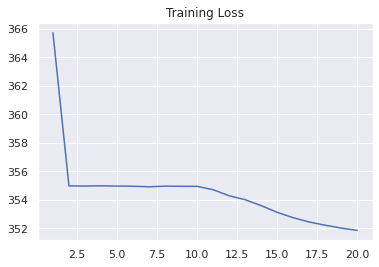

In [20]:
plt.plot([x[0] for x in training_losses], [x[1] for x in training_losses])
plt.title('Training Loss')
plt.show()

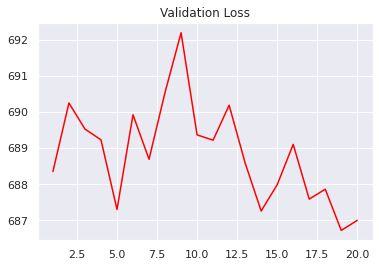

In [21]:
plt.plot([x[0] for x in validation_losses], [x[1] for x in validation_losses], color='red')
plt.title('Validation Loss')
plt.show()

# Evaluate Model

In [22]:
preds = net(X_train.to(device)).detach().cpu().numpy()
MSE(preds, y_train.cpu(), squared=False)

351.52963

In [23]:
preds = net(X_test.to(device)).detach().cpu().numpy()
MSE(preds, y_test.cpu(), squared=False)

686.99713

# Make Predictions

In [24]:
# prediction
df_te = df_te[df_te['MISSING_DATA']==False]

# ohe
X_out = df_te[features_to_use]
for feat in features_to_use:
    X_out = compute_ohe(X_out, feat)
X_out = X_out.drop(columns=features_to_use)

X_out = torch.from_numpy(X_out.values).to(torch.float32)

In [25]:
preds_out = net(X_out.to(device)).detach().cpu().numpy()
df_out = pd.DataFrame(data = {'TRIP_ID': np.array(df_te['TRIP_ID']), 'TRAVEL_TIME': preds_out.flatten()})
df_out.to_csv('my_preds.csv', index=False)